# This is where I estimate baseline, naive, and ppi corrected inference parameters for each model classic, bert and gpt_zeroshot

In [3]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# load custom local packages
# sys.path.append("C:\\Users\\Adam\\Desktop\\code_projects\\GitHub\\va_nlp\\utils")
sys.path.append('/Users/adam/Desktop/Github/va_nlp/utils')

from dataset_utils import dataframe_decorator
from statistics_utils import *
from ppi_plusplus_multi import *

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## load data

In [13]:
df = pd.read_csv('../src/gpt_nlp/results_df.csv')
mexico_knn = pd.read_csv('../data/results/mexico_KNN.csv')
mexico_svm = pd.read_csv('../data/results/mexico_SVM.csv')
mexico_nb = pd.read_csv('../data/results/mexico_NB.csv')
mexico_bert = pd.read_csv('../data/results/mexico_bert.csv')
mexico_gpt4zs = pd.read_csv('../data/results/mexico_gpt4_zs.csv')

dar_bert = pd.read_csv('../data/results/dar_bert.csv')
up_bert = pd.read_csv('../data/results/up_bert.csv')

In [12]:
dar_bert['Y_hat'].value_counts()

Y_hat
4    1507
2      49
3       8
Name: count, dtype: int64

In [14]:
up_bert['Y_hat'].value_counts()

Y_hat
4    704
2    676
Name: count, dtype: int64

In [6]:
mexico_bert['Y_hat'].value_counts()

Y_hat
4    952
2    323
3     31
Name: count, dtype: int64

In [7]:
mexico_bert['Y'].value_counts()

Y
4    900
1    140
2    121
0    111
3     34
Name: count, dtype: int64

In [3]:
label_to_score = {
    'aids-tb': 0,
    'communicable': 1,
    'external': 2,
    'maternal': 3, 
    'non-communicable': 4, 
    'unclassified': 'unclassified'
}

cod_labels = ['aids-tb', 'communicable', 'external', 'maternal', 'non-communicable']

# Break into 80/20 split for Naive and PPI estimation

In [19]:
def data_split(df, test_size=0.2):
    '''
    Takes input df which has three columns, [Y, X, Y_hat]
    Subsets df to exclude 'unclassified' from Y_hat 
    returns data split unlabeled/labeled with a default 80/20 train/test split:
        Y_sorted (ndarray): All gold-standard labels, sorted. 
        X_sorted (ndarray): All covariates corresponding to the gold-standard labels, sorted. 
        Y_lab (ndarray) : test_size number of gold standard labels.
        Yhat_lab (ndarray): test_size number of predictions corresponding to the gold-standard labels.
        X_lab (ndarray) : test_size number of covariates corresponding to the gold-standard labels.        
        Yhat_unlabeled (ndarray): (1-test_size) number of predictions corresponding to the gold-standard labels.
        X_unlabeled (ndarray): (1-test_size) number of covariates corresponding to the unlabeled data.
             
    '''
    
    # subset to exclude unclassified predictions
    df = df[df['Y_hat']!='unclassified'].astype(int)
    
    # random split
    np.random.seed(123)
    labeled_df = df.sample(frac=test_size)
    unlabeled_df = df.drop(labeled_df.index)
    
    # not split
    Y = df['Y'].to_numpy()
    X = df['X'].to_numpy()
    X = X.reshape(-1,1)
    Yhat = df['Y_hat'].to_numpy()
    sort_idx1 = np.argsort(Y)
    Y_sorted = Y[sort_idx1]
    X_sorted = X[sort_idx1]
    Yhat_sorted = Yhat[sort_idx1]

    # labeled split
    Y_lab = labeled_df['Y'].to_numpy()
    X_lab = labeled_df['X'].to_numpy()
    X_lab = X_lab.reshape(-1,1)
    Yhat_lab = labeled_df['Y_hat'].to_numpy()
    
    # unlabeled split
    Y_unlab = unlabeled_df['Y'].to_numpy()
    X_unlab = unlabeled_df['X'].to_numpy()
    X_unlab = X_unlab.reshape(-1,1)
    Yhat_unlab = unlabeled_df['Y_hat'].to_numpy()
        
    # combine labeled with unlabeled
    Y_full = np.concatenate((Y_lab, Yhat_unlab))
    X_full = np.concatenate((X_lab, X_unlab))
    sort_idx2 = np.argsort(Y_full)
    Y_full_sorted = Y_full[sort_idx2]
    X_full_sorted = X_full[sort_idx2]
    
    return Y_sorted, X_sorted, Yhat_sorted, Y_lab, X_lab, Yhat_lab, Y_unlab, X_unlab, Yhat_unlab, Y_full_sorted, X_full_sorted

In [20]:
Y_sorted, X_sorted, Yhat_sorted, Y_lab, X_lab, Yhat_lab, Y_unlab, X_unlab, Yhat_unlab, Y_full_sorted, X_full_sorted = data_split(mexico_bert)


# Functions to estimate and return baseline, naive and ppi++ inference estimates

In [21]:
def baseline_inference(Ylab, Xlab):
    '''
    Ylab (ndarray): true Y labels
    Xlab (ndarray): true X values
    perform MNLogistic regression Y~X
    returns lists of point estimates and confidence intervals
    '''
    
    mn_logit = sm.MNLogit(Ylab, Xlab)
    mn_logit_res = mn_logit.fit(method = "newton", full_output = True)
    pe = mn_logit_res.params
    ci = mn_logit_res.conf_int()
    
    return pe, ci

In [22]:
pe, ci = baseline_inference(Y_sorted, X_sorted)

Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7


In [23]:
pe

array([[ 0.01251579,  0.00399583, -0.02938669,  0.04290408]])

In [24]:
ci

array([[[ 0.00745418,  0.0175774 ]],

       [[-0.00158093,  0.00957259]],

       [[-0.03947504, -0.01929834]],

       [[ 0.03854903,  0.04725912]]])

In [25]:
def naive_inference(Ylab, Xlab):
    '''
    Ylab (ndarray): true Y labels
    Xlab (ndarray): true X values
    perform MNLogistic regression on 80/20 unlabeled/labeled split Y_combined ~ X_combined
    returns lists of point estimates and confidence intervals
    '''
    
    mn_logit = sm.MNLogit(Y_full_sorted, X_full_sorted)
    mn_logit_res = mn_logit.fit(method = "newton", full_output = True)
    pe = mn_logit_res.params
    ci = mn_logit_res.conf_int()
   
    return pe, ci

In [26]:
pe, ci = naive_inference(Y_full_sorted, X_full_sorted)

Optimization terminated successfully.
         Current function value: 0.818104
         Iterations 7


In [27]:
pe

array([[0.01972783, 0.06115925, 0.01225632, 0.08184039]])

In [28]:
ci

array([[[ 0.00652206,  0.0329336 ]],

       [[ 0.04965909,  0.07265941]],

       [[-0.00175172,  0.02626436]],

       [[ 0.07044985,  0.09323093]]])

In [29]:
def ppi_inference(X, Y, Yhat, X_unlabeled, Yhat_unlabeled):
    '''
    X (ndarray): Covariates corresponding to the gold-standard labels.
    Y (ndarray): Gold-standard labels.
    Yhat (ndarray): Predictions corresponding to the gold-standard labels.
    X_unlabeled (ndarray): Covariates corresponding to the unlabeled data.
    Yhat_unlabeled (ndarray): Predictions corresponding to the unlabeled data.
    perform ppi++ corrected MNLogit on 80/20 unlabeled/labeled
    returns lists of point estimates and confidence intervals
    '''
    
    theta_ppi_ci = ppi_multiclass_logistic_ci(
                X=X_lab,
                Y=Y_lab,
                Yhat=Yhat_lab,
                X_unlabeled=X_unlab,
                Yhat_unlabeled=Yhat_unlab,
                optimizer_options = {'disp': True, 'maxiter':1000},
            )
    
    pe = theta_ppi_ci['pointest']
    ci = theta_ppi_ci['ci']
    lhat = theta_ppi_ci['lhat']
    se = theta_ppi_ci['se']
   
    return pe, ci, lhat, se

In [30]:
pe, ci, lhat, se = ppi_inference(
    X=X_lab,
    Y=Y_lab,
    Yhat=Yhat_lab,
    X_unlabeled=X_unlab,
    Yhat_unlabeled=Yhat_unlab,
)

In [31]:
pe

array([ 0.01513981, -0.00346957, -0.02031198,  0.04476595])

In [32]:
ci

(array([ 0.00278088, -0.01275375, -0.0446409 ,  0.03759806]),
 array([0.02749875, 0.00581461, 0.00401694, 0.05193385]))

In [18]:
for i in range(1):
    try:
        # PPI++ correction using the same 80/20 split unlabeled/labeled
        theta_ppi_ci = ppi_multiclass_logistic_ci(
            X=X_lab,
            Y=Y_lab,
            Yhat=Yhat_lab,
            X_unlabeled=X_unlab,
            Yhat_unlabeled=Yhat_unlab,
            optimizer_options = {'disp': True, 'maxiter':1000},
        )
        print(theta_ppi_ci)
    except Exception as e:
        # Handle the exception (if needed)
        print("Error:", e)
        # Continue with the loop
        continue


KeyboardInterrupt



# Site: geographic regions (mexico, ap, up, dar, bohol, pemba)
# Model: ai prediction model (classic, BERT, GPT4)
# Inference: type of inference (Baseline, Naive, PPI++)

# Loop through all permutations, compute PE and CI, save results 

In [48]:
sites = df['site'].unique()
models = ['KNN', 'SVM', 'NB', 'bert', 'gpt4_zs']
results_list = []
column_names=  [
    'site', 'model',
    'baseline_pe', 'baseline_ci',
    'naive_pe', 'naive_ci',
    'ppi_pe', 'ppi_ci', 'ppi_lhat', 'ppi_se'
]

np.random.seed(42)
for site in tqdm(sites):
    for model in tqdm(models):
        # read in dataframe for site and model
        load_df = pd.read_csv(f'../data/results/{site}_{model}.csv')

        # split data 
        Y_sorted, X_sorted, Yhat_sorted, Y_lab, X_lab, Yhat_lab, Y_unlab, X_unlab, Yhat_unlab, Y_full_sorted, X_full_sorted = data_split(load_df)

        try:
            # baseline predictions
            baseline_pe, baseline_ci = baseline_inference(Y_sorted, X_sorted)

            # naive predictions
            naive_pe, naive_ci = naive_inference(Y_full_sorted, X_full_sorted)

            # ppi++ predictions
            ppi_pe, ppi_ci, ppi_lhat, ppi_se = ppi_inference(
                X=X_lab,
                Y=Y_lab,
                Yhat=Yhat_lab,
                X_unlabeled=X_unlab,
                Yhat_unlabeled=Yhat_unlab,
            )

        except Exception as e:
            # Handle the exception (if needed)
            print("Error:", e)
            # Continue with the loop
            continue

        result = [
            site, model,
            baseline_pe, baseline_ci,
            naive_pe, naive_ci,
            ppi_pe, ppi_ci, ppi_lhat, ppi_se
        ]

        results_list.append(result)

# Create DataFrame
results_df = pd.DataFrame(results_list, columns=column_names)

# write to results folder
results_df.to_csv('../data/results/estimation_results.csv', index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.824738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.699056
         Iterations 7
Error: Singular matrix
Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.961287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.818104
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.068674
         Iterations 7
Optimization terminated successfully.
         Current func

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.228118
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.030722
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.228118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.922293
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.228118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.502735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502735
         Iterations 5
Error: index 4 is out of bounds for axis 0 with size 2
Optimization terminated successfully.
         Current function value: 1.224239
         Iterations 6
Optimization terminated suc

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.283214
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.048470
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.283214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.942132
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.283214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690714
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690714
         Iterations 3
Error: index 4 is out of bounds for axis 0 with size 2
Optimization terminated successfully.
         Current function value: 1.281369
         Iterations 6
Optimization terminated suc

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.180551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595348
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.180551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610401
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.180551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.160539
         Iterations 9
Error: index 4 is out of bounds for axis 0 with size 3
Optimization terminated successfully.
         Current function value: 1.222207
         Iterations 6
Optimization terminated suc

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.010036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.807817
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.010036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689003
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.010036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390735
         Iterations 10
Error: index 4 is out of bounds for axis 0 with size 3
Optimization terminated successfully.
         Current function value: 1.013905
         Iterations 7
Optimization terminated s

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.390964
         Iterations 7
Error: index 4 is out of bounds for axis 0 with size 4
Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.157168
         Iterations 7
Error: index 4 is out of bounds for axis 0 with size 4
Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.786157
         Iterations 6
Error: index 4 is out of bounds for axis 0 with size 4
Optimization terminated successfully.
         Current function value: 1.435306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.854723
         Iterations 7
Error: index 4 is o

In [49]:
results_df.shape

(21, 10)

In [57]:
results_df.head()

,site,model,baseline_pe,baseline_ci,naive_pe,naive_ci,ppi_pe,ppi_ci,ppi_lhat,ppi_se
0,mexico,KNN,"[[0.012515790064988281, 0.003995833892191644, ...","[[[0.007454184279145517, 0.017577395850831047]...","[[0.00011150771769032654, -0.00022515495015714...","[[[-0.006128794574323335, 0.006351810009703989...","[0.01435740972202285, -0.008235184470381478, -...","([0.0022773081546547235, -0.018403764141861793...",0.134742,"[0.007344180278069523, 0.00618205748211559, 0...."
1,mexico,NB,"[[0.012515790064988281, 0.003995833892191644, ...","[[[0.007454184279145517, 0.017577395850831047]...","[[0.021018400428029514, 0.01492494851651018, -...","[[[0.007387433606168696, 0.03464936724989033]]...","[0.015525031299500712, -0.00728788617626402, -...","([0.003626519834836842, -0.017817244195128656,...",0.648715,"[0.007233781334522911, 0.006401395143213725, 0..."
2,mexico,bert,"[[0.012515790064988281, 0.003995833892191644, ...","[[[0.007454184279145517, 0.017577395850831047]...","[[0.01972782844845568, 0.061159248977691295, 0...","[[[0.00652205807740079, 0.03293359881951057]],...","[0.015139814683745296, -0.003469571567098199, ...","([0.002780875035907635, -0.012753752116796952,...",0.016621,"[0.00751370179408814, 0.005644380993891722, 0...."
3,mexico,gpt4_zs,"[[0.0110555829376927, 0.007075625152646621, -0...","[[[0.003246674824665257, 0.018864491050720144]...","[[0.002810334077492071, 0.014345259295838705, ...","[[[-0.007138905030868588, 0.01275957318585273]...","[0.006299391625313843, 0.0069232869260084165, ...","([-0.010039719978275203, -0.001538414808634780...",0.739241,"[0.009933474526770823, 0.005144349379176, 0.01..."
4,ap,KNN,"[[-0.004020411834614707, 0.00446088050615213, ...","[[[-0.009293965661295183, 0.001253141992065768...","[[0.023502322559859925, 0.02848662820615018, -...","[[[0.015335092614406758, 0.031669552505313094]...","[0.007346149296554269, 0.004868703058435458, -...","([-0.0036295441386539253, -0.00135403044605871...",0.606691,"[0.0066727478089039765, 0.0037831533472234952,..."


In [53]:
results_df['site'].value_counts()

site
mexico    4
ap        4
up        4
dar       4
bohol     4
pemba     1
Name: count, dtype: int64

In [54]:
results_df['model'].value_counts()

model
gpt4_zs    6
KNN        5
NB         5
SVM        4
bert       1
Name: count, dtype: int64

In [63]:
results_df.iloc[0]['ppi_pe']

array([ 0.01435741, -0.00823518, -0.01918385,  0.04426635])

In [67]:
results_df.iloc[0]['ppi_ci']

(array([ 0.00227731, -0.01840376, -0.041147  ,  0.03732461]),
 array([0.02643751, 0.0019334 , 0.0027793 , 0.05120809]))

# For each site/model/inference permutation, plot to compare the PE + CI 

In [168]:
def plot_with_errorbars(site_name, model_name,
                        baseline_pe, naive_pe, ppi_pe, 
                        baseline_ci, naive_ci, ppi_ci):
    '''
    site_name (str): Name of the site for inference from ['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']
    model_name (str): Name of the model used from ['KNN', 'NB', 'bert', 'gpt4_zs', 'SVM'].
    baseline_pe (ndarray shape (1,4)): Point estimates from baseline inference. 
    naive_pe (ndarray shape (1,4)): Point estimates from naive inference. 
    ppi_pe (ndarray shape (4,)): Point estimates from ppi++ inference. 
    baseline_ci (ndarray shape (4, 1, 2)): 95% confidence interval estimates from baseline inference. 
    naive_ci (ndarray shape (4, 1, 2)): 95% confidence interval estimates from naive inference. 
    ppi_ci (tuple of ndarrays shape (4,)): 95% confidence interval estimates from ppi++ inference. 

    This function makes a dot plot with 95% CI error bars to compare the baseline, naive
    and ppi++ inference parameters for the given site and model.
    '''
    
    # Define labels for x-axis (models)
    labels = cod_labels[1:]

    # Define positions for each model
    x = np.arange(len(labels))

    # Define width of each bar
    width = 0.2

    # Create the plot
    fig, ax = plt.subplots()

    # Plot point estimates
    ax.scatter(x - width, baseline_pe.flatten(), color='blue', label='Fully Labeled')
    ax.scatter(x, naive_pe.flatten(), color='red', label='Naive')
    ax.scatter(x + width, ppi_pe, color='green', label='PPI++ Adjusted')

    # Plot error bars
    ax.errorbar(x - width, baseline_pe.flatten(), yerr=np.abs(baseline_ci[:,:,0].flatten() - baseline_pe.flatten()), fmt='none', color='blue')
    ax.errorbar(x, naive_pe.flatten(), yerr=np.abs(naive_ci[:,:,0].flatten() - naive_pe.flatten()), fmt='none', color='red')
    ax.errorbar(x + width, ppi_pe, yerr=np.abs(ppi_ci[0] - ppi_pe), fmt='none', color='green')

    # Add labels, title, and legend
    ax.set_ylabel('Point Estimate')
    ax.set_xlabel('Cause of Death Label')
    ax.set_title(f'{site_name} {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    return fig

  0%|          | 0/21 [00:00<?, ?it/s]

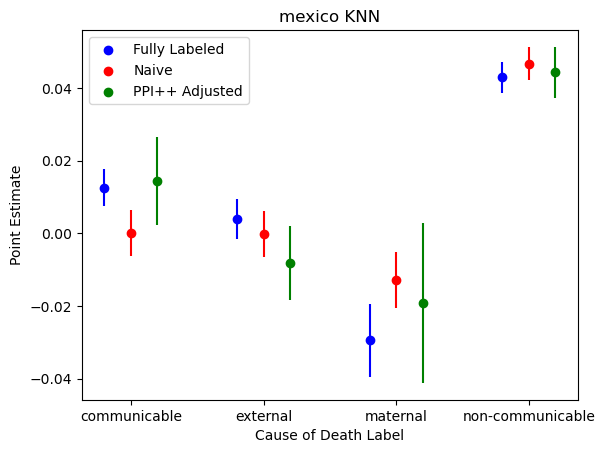

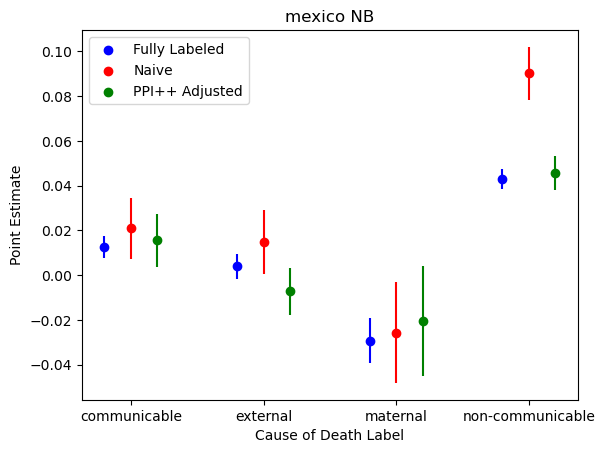

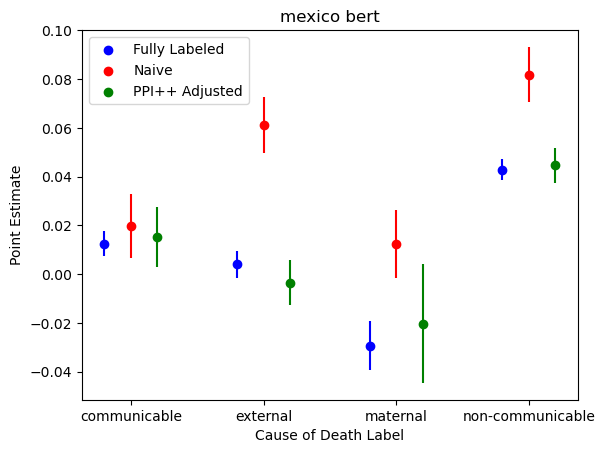

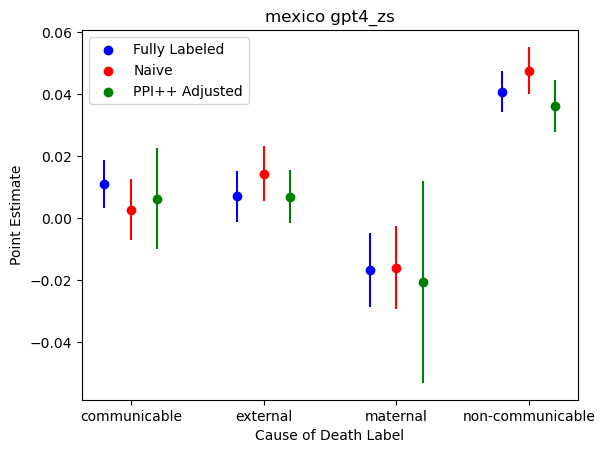

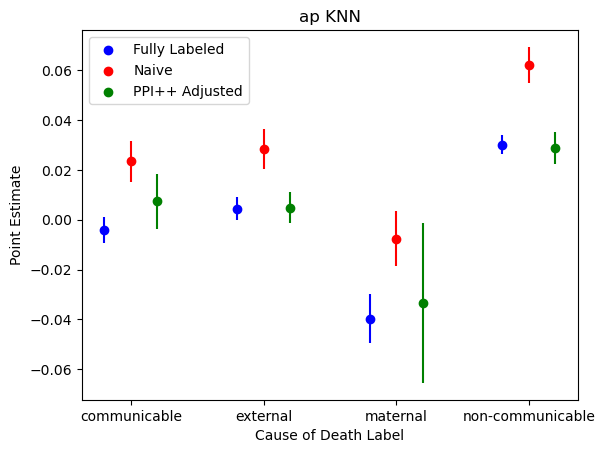

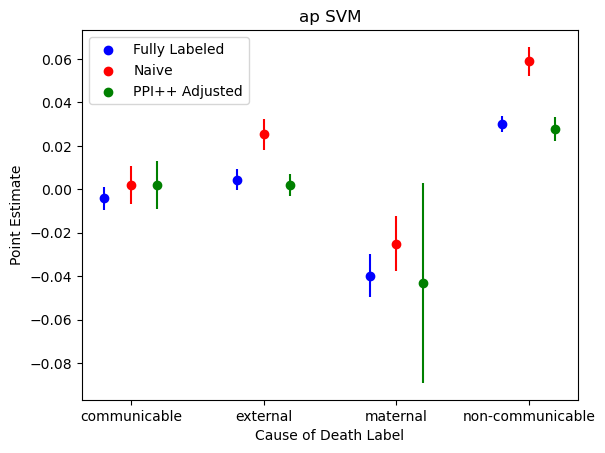

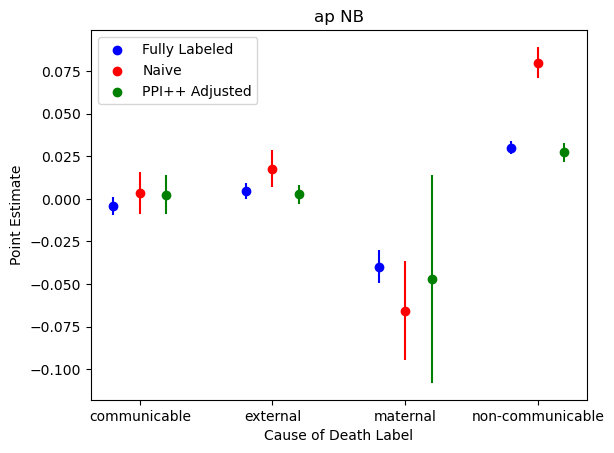

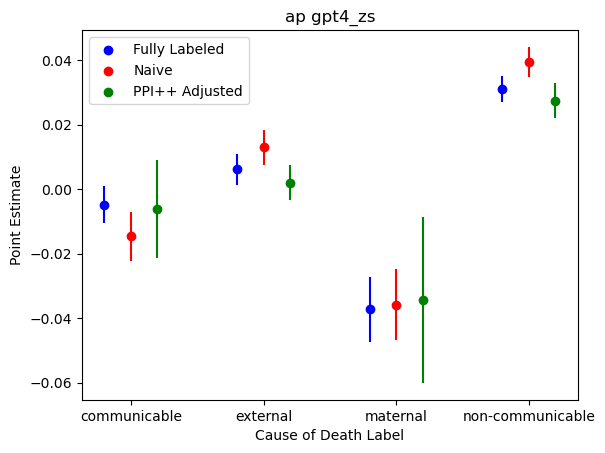

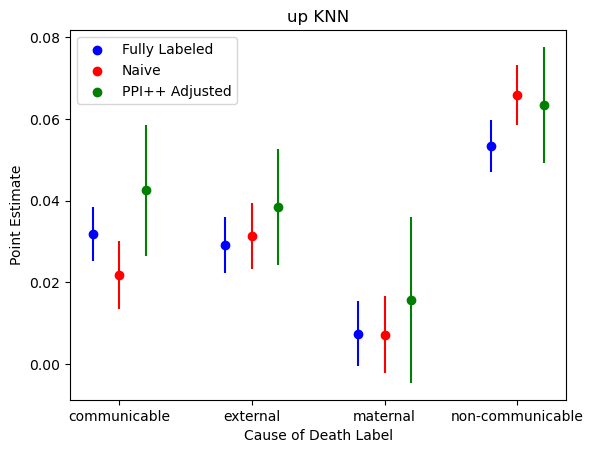

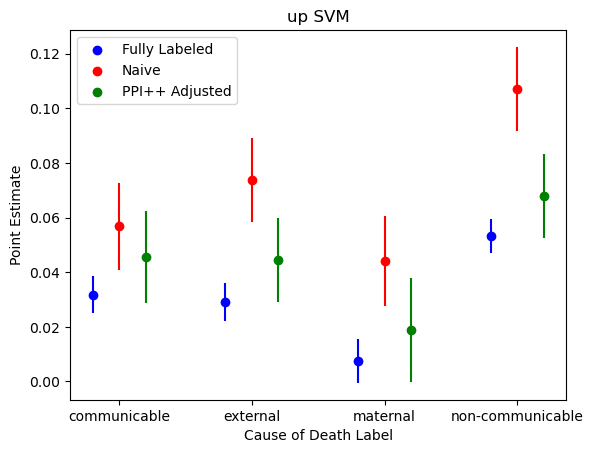

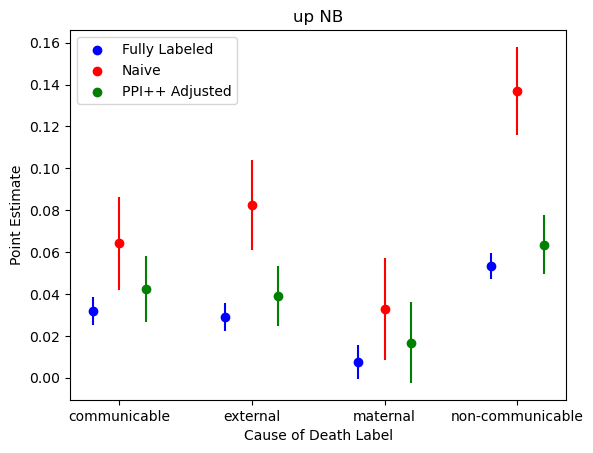

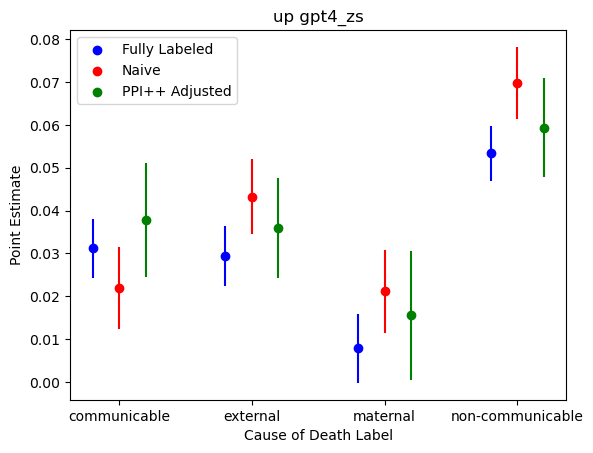

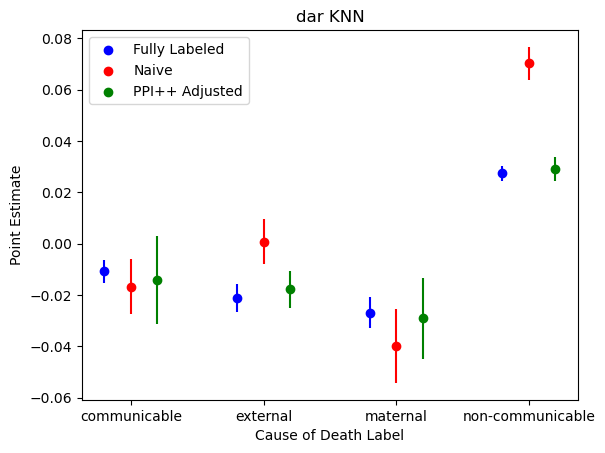

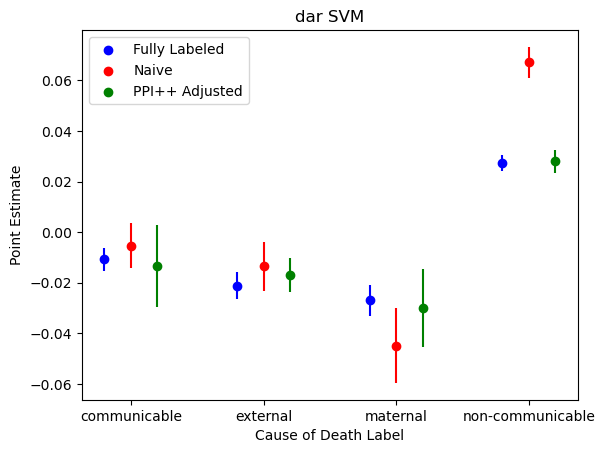

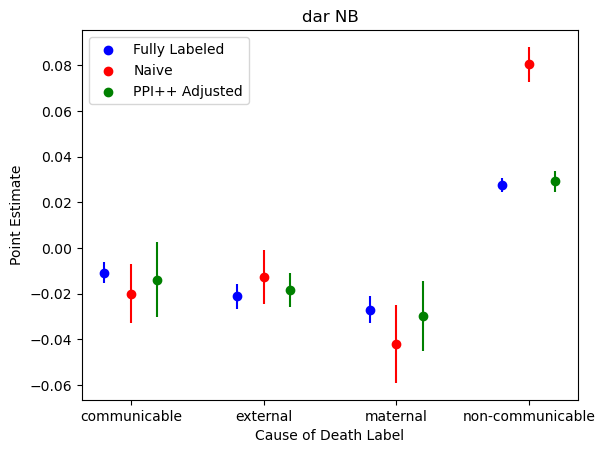

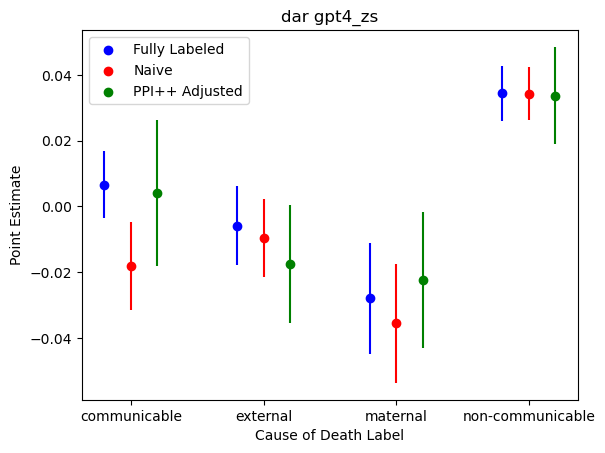

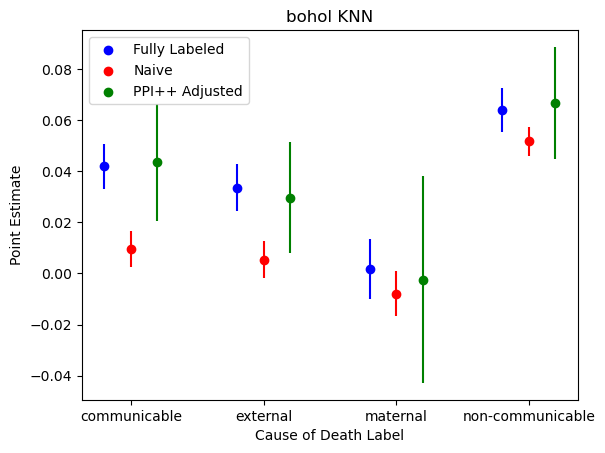

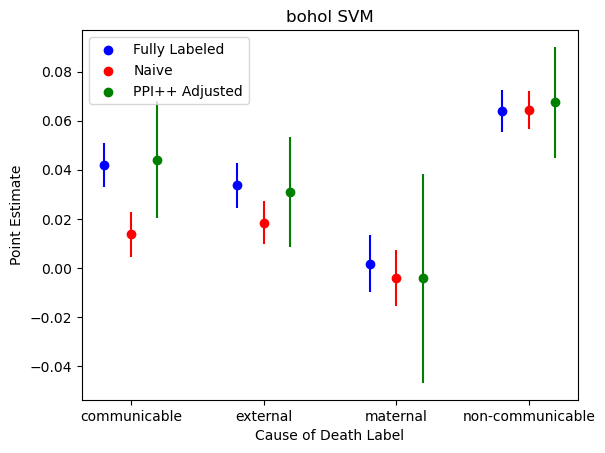

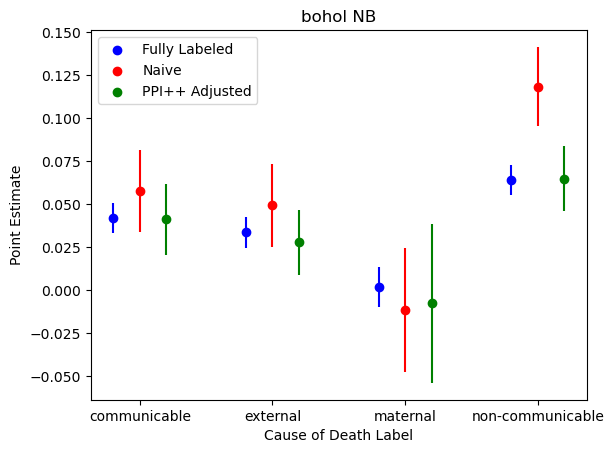

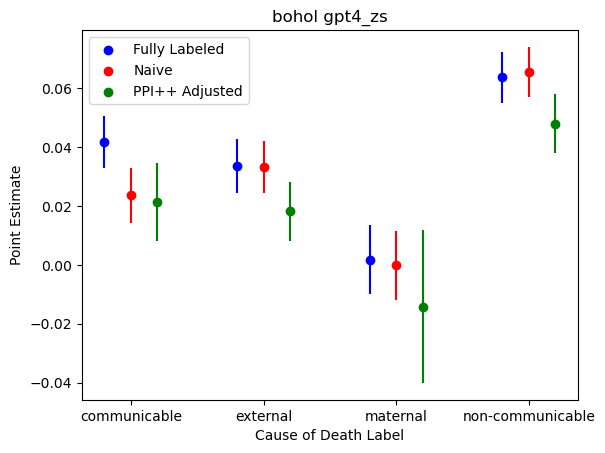

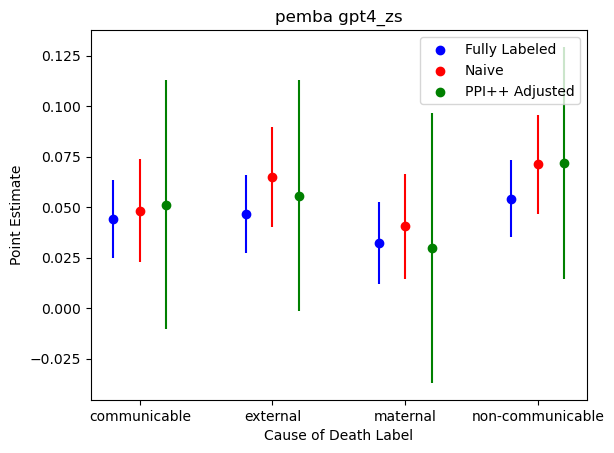

In [169]:
# Create PDF to save plots
pdf_pages = PdfPages('../data/results/inference_results.pdf')

# loop through rows of results_df
for row in tqdm(range(results_df.shape[0])):
    site_name = results_df.iloc[row]['site']
    model_name = results_df.iloc[row]['model']
    baseline_pe = results_df.iloc[row]['baseline_pe']
    naive_pe = results_df.iloc[row]['naive_pe']
    ppi_pe = results_df.iloc[row]['ppi_pe']
    baseline_ci = results_df.iloc[row]['baseline_ci']
    naive_ci = results_df.iloc[row]['naive_ci']
    ppi_ci = results_df.iloc[row]['ppi_ci']
    
    # make plot
    fig = plot_with_errorbars(site_name, model_name,
                          baseline_pe, naive_pe, ppi_pe, 
                          baseline_ci, naive_ci, ppi_ci)

    # save to pdf
    pdf_pages.savefig(fig)

# Close the PDF
pdf_pages.close()